In [1]:
import pandas as pd
import pandas as pd
import sklearn as sk
from prophet import Prophet
from  pandas import to_datetime
import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import numpy as np

In [2]:
#pip install prophet

In [3]:
data = pd.read_csv("M0424_2562_RMF.csv")

In [4]:
df1 = data[["nav_date","last_val"]]

In [5]:
num = 5

In [6]:
df1['nav_date'] = pd.to_datetime(df1['nav_date'])

C:\Users\taro\AppData\Local\Temp\ipykernel_15608\1053568752.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['nav_date'] = pd.to_datetime(df1['nav_date'])


In [7]:
df1.head()

,nav_date,last_val
0,2019-09-11,9.9669
1,2019-09-12,9.9233
2,2019-09-13,9.9754
3,2019-09-16,9.9887
4,2019-09-17,10.0096


In [8]:
monthly_avg = df1.set_index('nav_date').resample('M').mean()

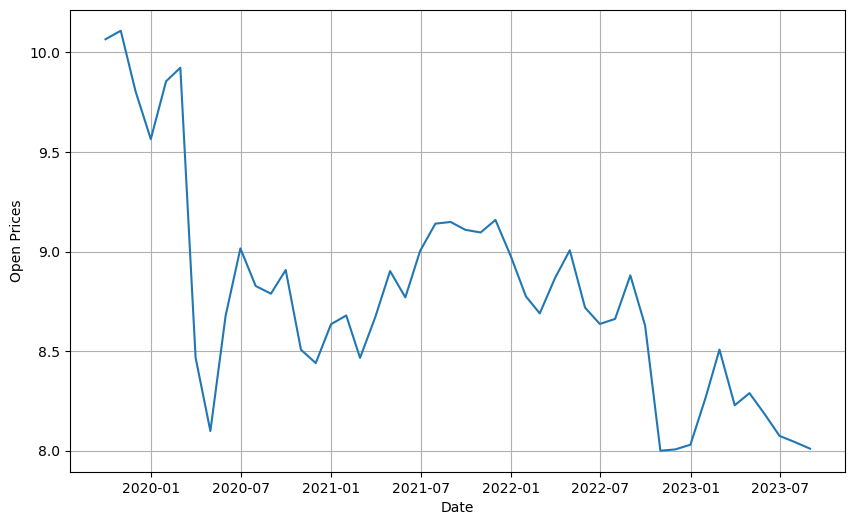

In [9]:
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Open Prices')
plt.plot(monthly_avg)

plt.show()

In [10]:
monthly_avg = monthly_avg.reset_index()

In [11]:
monthly_avg.isnull().sum()

nav_date    0
last_val    0
dtype: int64

In [12]:
monthly_avg = monthly_avg.dropna()

In [13]:
df = pd.DataFrame(monthly_avg)

In [14]:
df.columns = ['ds', 'y']
df['ds']= to_datetime(df['ds'])

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48 entries, 0 to 47
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      48 non-null     datetime64[ns]
 1   y       48 non-null     float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 900.0 bytes


In [16]:
train_data = df.iloc[:-num]
test_data = df.iloc[-num:]
print("train size: {} , test size: {}".format(len(train_data),len(test_data)))

train size: 43 , test size: 5


In [17]:
scaler = MinMaxScaler(feature_range = (0,1))
train_scaled = scaler.fit_transform(train_data["y"].values.reshape(-1,1))
#test_scaled = scaler.transform(test_data["y"].values.reshape(-1,1))
#df_scaled = result = np.append(train_scaled, test_scaled)

In [18]:
train_data["y"] = train_scaled

C:\Users\taro\AppData\Local\Temp\ipykernel_15608\52025879.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data["y"] = train_scaled


In [19]:
m = Prophet(changepoint_prior_scale=0.5,seasonality_prior_scale=0.5)
m.fit(train_data)

03:08:32 - cmdstanpy - INFO - Chain [1] start processing
03:08:32 - cmdstanpy - INFO - Chain [1] done processing


In [20]:
future = m.make_future_dataframe(periods=5,freq='M')
future.tail()

,ds
43,2023-04-30
44,2023-05-31
45,2023-06-30
46,2023-07-31
47,2023-08-31


In [21]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
43,2023-04-30,0.066260,-0.056391,0.183179
44,2023-05-31,-0.022486,-0.146553,0.102001
45,2023-06-30,0.002564,-0.118947,0.131047
46,2023-07-31,0.037115,-0.094158,0.164009
47,2023-08-31,0.105322,-0.023210,0.239309


In [22]:
forecast['yhat']

0     1.068773
1     0.929459
2     0.814447
3     0.701646
4     0.738159
5     0.719771
6     0.378460
7     0.284444
8     0.350685
9     0.438352
10    0.398882
11    0.393674
12    0.391768
13    0.253076
14    0.256721
15    0.300637
16    0.335629
17    0.448395
18    0.297334
19    0.328959
20    0.378879
21    0.478310
22    0.497646
23    0.552484
24    0.512395
25    0.417791
26    0.425633
27    0.420713
28    0.453588
29    0.447736
30    0.333340
31    0.339398
32    0.299730
33    0.341599
34    0.347718
35    0.389135
36    0.261179
37    0.159795
38    0.121734
39    0.098999
40    0.170225
41    0.083556
42    0.047737
43    0.066260
44   -0.022486
45    0.002564
46    0.037115
47    0.105322
Name: yhat, dtype: float64

In [23]:
forecast_in = scaler.inverse_transform(forecast[['yhat']])

In [24]:
forecast_in1 = pd.DataFrame()

In [25]:
forecast_in1["yhat"] = pd.DataFrame(forecast_in)

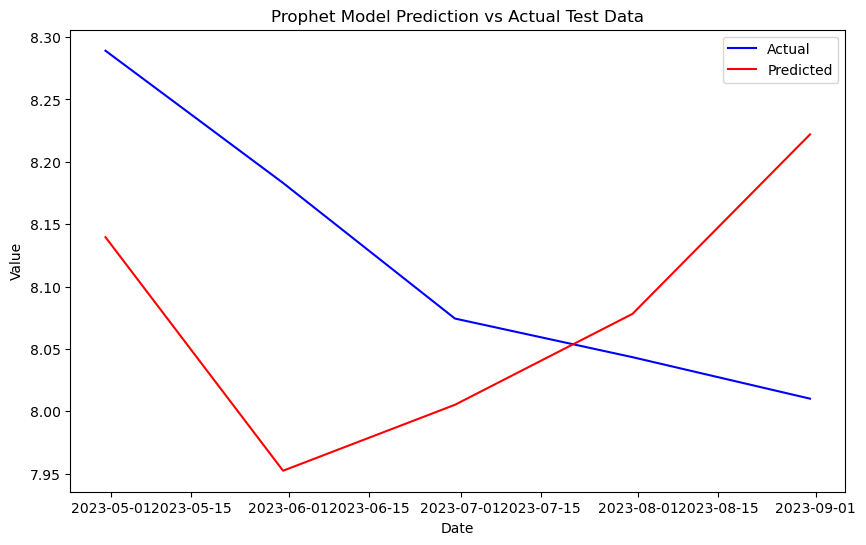

In [26]:
plt.figure(figsize=(10, 6))
plt.plot(test_data['ds'], test_data['y'], label='Actual', color='blue')
plt.plot(test_data['ds'], forecast_in1['yhat'][-5:], label='Predicted', color='red')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Prophet Model Prediction vs Actual Test Data')
plt.show()

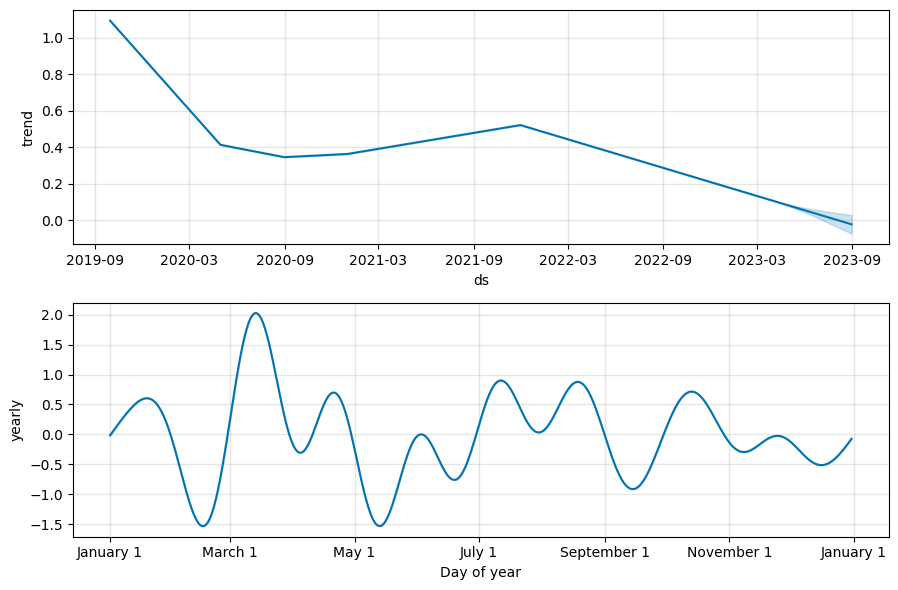

In [27]:
fig2 = m.plot_components(forecast)

In [28]:
MSE_error = mean_squared_error(test_data["y"], forecast_in1["yhat"][-num:])
print('Testing Mean Squared Error is {}'.format(MSE_error))

Testing Mean Squared Error is 0.025279178760385067
